In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

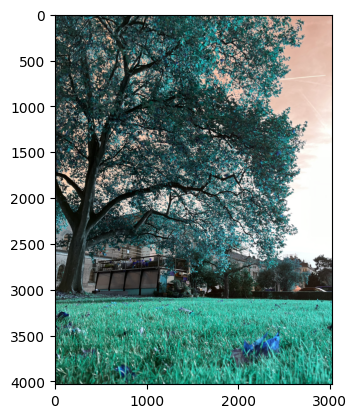

In [2]:
filename = input("Filename: ")
tree_img = cv2.imread('measuredTrees/' + filename)
plt.imshow(tree_img)

In [3]:
distance = 5
pos_az = 10

variation = 200

sun_radius_deg = 0.533

res_x = tree_img.shape[1]
res_y = tree_img.shape[0]
pix_deg = res_x / 65

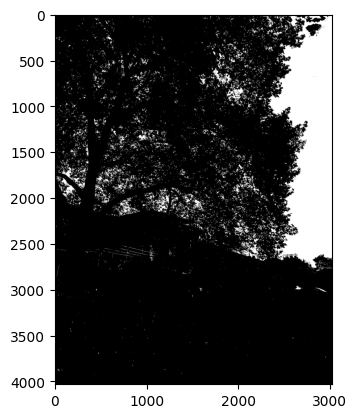

In [4]:
lower_bound = np.array([220, 0, 0])
upper_bound = np.array([360, 255, 255])

mask = cv2.inRange(tree_img, lower_bound, upper_bound)

#cv2.imshow('treemask', imagemask)
plt.imshow(mask, cmap='gray')

In [5]:
cv2.imwrite("C:/Users/patri/OneDrive/Bilder/Tree/test_tree_gray1.jpg", mask)

True

In [6]:
sun_x = int(input("Sun position X: "))#1517
sun_y = int(input("Sun position Y: "))#1467

sun_radius = int(sun_radius_deg * pix_deg) // 2

pos_x = np.arange(sun_x-sun_radius*4, sun_x+sun_radius*4, int(sun_radius/8))
pos_y = np.arange(sun_y-sun_radius*4, sun_y+sun_radius*4, int(sun_radius/8))

coords = np.array(np.meshgrid(pos_x, pos_y, )).T.reshape(-1, 2)


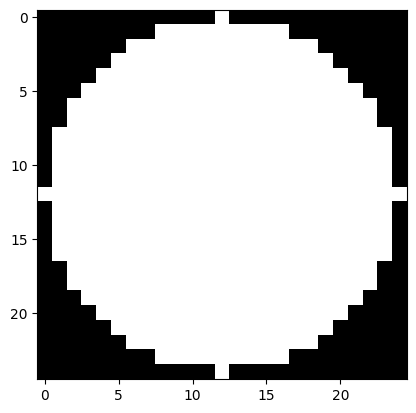

In [7]:
circle_mask = cv2.circle(np.zeros((sun_radius*2+1,sun_radius*2+1), dtype=int), (sun_radius,sun_radius), sun_radius, 255, -1)
plt.imshow(circle_mask, cmap='gray')

In [8]:
cropped_tree = np.array([np.repeat([mask[0:sun_radius*2+1, 0:sun_radius*2+1]], pos_y.size, axis=0)])
for x in pos_x:
    cropped_y = np.array([mask[0:sun_radius*2+1, 0:sun_radius*2+1]])
    for y in pos_y:
        cropped_y = np.append(cropped_y, [mask[y-sun_radius:y+sun_radius+1, x-sun_radius:x+sun_radius+1]], axis=0)
    cropped_y = np.delete(cropped_y, 0, axis=0)
    cropped_tree = np.append(cropped_tree, [cropped_y], axis=0)
cropped_tree = np.delete(cropped_tree, 0, axis=0)

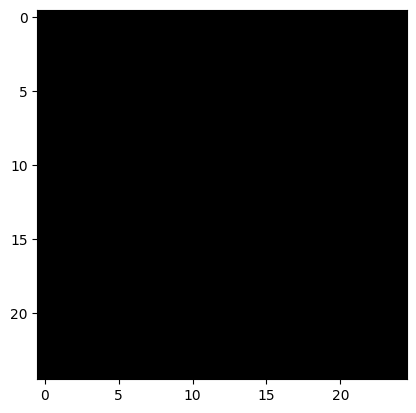

In [9]:
masked_tree = cropped_tree * circle_mask // 65025
plt.imshow(masked_tree[1][1], cmap='gray')

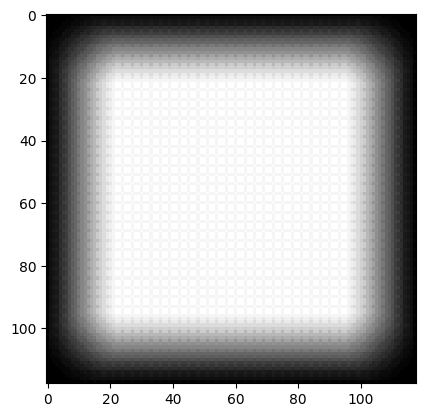

In [10]:
min_x = np.min(pos_x) - sun_radius
min_y = np.min(pos_y) - sun_radius
max_x = np.max(pos_x) + sun_radius + 1
max_y = np.max(pos_y) + sun_radius + 1

rel_x = pos_x - min_x
rel_y = pos_y - min_y

rel_coords = np.array(np.meshgrid(rel_x, rel_y, )).T.reshape(-1, 2)

size_x = max_x - min_x
size_y = max_y - min_y

visualization = np.zeros((size_y, size_x), dtype=int)

for crd in rel_coords:
    x = crd[0]
    y = crd[1]
    visualization[y-sun_radius:y+sun_radius+1,x-sun_radius:x+sun_radius+1] = np.add(visualization[y-sun_radius:y+sun_radius+1,x-sun_radius:x+sun_radius+1], circle_mask)

plt.imshow(visualization, cmap='gray')

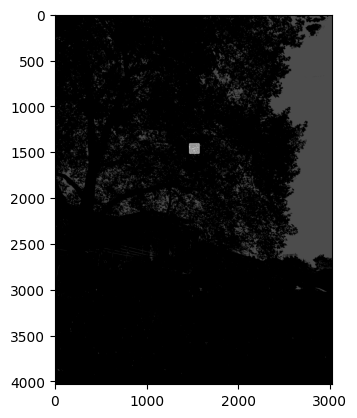

In [11]:
alpha = 0.3
beta = 1 - alpha

overlay = np.zeros_like(mask)
overlay[min_y:max_y,min_x:max_x] = visualization

whole_visualization = cv2.addWeighted(mask, alpha, overlay, beta, 0.0)

plt.imshow(whole_visualization, cmap='gray')

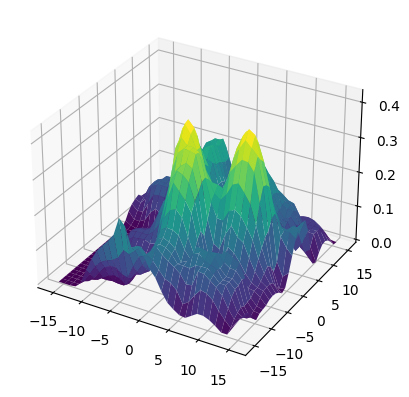

In [12]:
lai = (np.apply_over_axes(np.sum, masked_tree, [2,3]) / (np.sum(circle_mask) // 255)).reshape(len(masked_tree),-1)


x = np.linspace(-(len(lai)-1)/2, (len(lai)-1)/2, len(lai))
y = x

X, Y = np.meshgrid(x, y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, lai, rstride=1, cstride=1, cmap='viridis')
#plt.show()
#plt.imshow(lai)

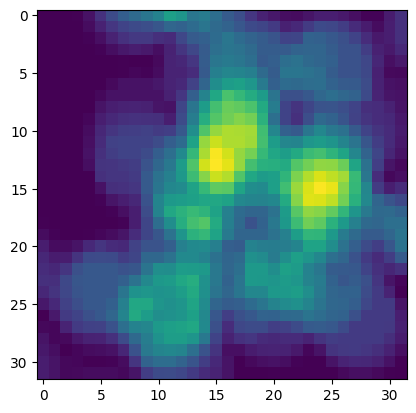

In [13]:
plt.imshow(lai)

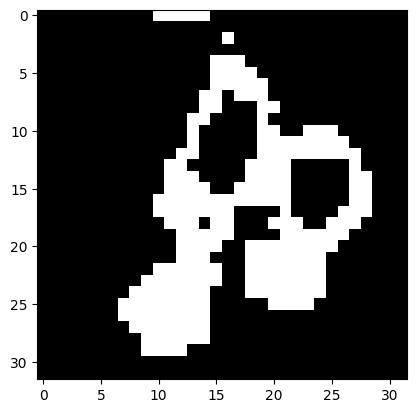

In [14]:
min_transmission = float(input("Transmission min: "))
max_transmission = float(input("Transmission max: "))

matched_values = np.logical_and(lai >= min_transmission, lai <= max_transmission)

plt.imshow(matched_values, cmap="gray")
plt.savefig("compare/" + filename[:-4] + "_3d.png")